In [8]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import nilearn
from nilearn import input_data
from nilearn.input_data import NiftiMasker
from nilearn import plotting
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import scale
from nilearn.image.image import mean_img
from nilearn.image import index_img
from nilearn.decomposition import DictLearning, CanICA
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show, plot_epi, plot_prob_atlas, find_xyz_cut_coords, plot_roi
from nilearn import datasets
from nilearn.plotting import plot_roi, plot_epi, show
from sklearn.cluster import FeatureAgglomeration
from sklearn.feature_extraction import image
from nilearn.masking import apply_mask
from nilearn.input_data import NiftiMasker
import time
import pandas as pd

import nibabel as nib
import matplotlib
import glob
import pickle
#import keras
#from keras.models import load_model
#from keras import models



plt.style.use('fivethirtyeight')
import os
import gzip
import shutil


### Functional and anatomical images
Functional magnetic resonance images(fMRI) consists of a sequence of 3D scans of the brain recorded over time. Here, we will refer to those images as "functional", while we will call "anatomical" those ones which don't have the time dimension (for example T1 or T2). These images are characterized by higher resolution and thus can be used as a reference for advanced image processing transformations.

For each subject we have between 1 and 3 sessions of resting state (RS) fMRI scans. Resting state is a condition for which the recording is performed while the subject is not performing any task (at rest). In literature it has been shown that from this condition it is possible to detect networks of the brain that are always active. These networks, which have been found to be consistent in healthy subjects, are destroyed in many neurological diseases. 

Furthermore, for each subject we have different anatomical scans. In particular we will be interested in T1 scans that will be used to align and normalize the functional data.

### Subjects
Subjects can be divided in two groups: 

* Parkinson's disease 

* Control


# Summary

### 0) Format conversion

### 1) Data inspection

### 2) Data structure organization (BIDS: http://bids.neuroimaging.io/)

### 3) Run the preprocessing pipeline 

### 4) Clustering and classification

### 5) CNN 

# 0) Format conversion
 The data was converted from DICOM to NIfTI running the following function on the cluster:

```
dcm2niix -b y -f %i_%d_%t -o ./PPMI_formatted/ ./PPMI/
``` 

Manual corrections were applied later to the the files that were not converted properly. 

# 1) Data inspection
Here we are going to inspect the NIfTI files obtained through the format conversion.
The names of the images have been saved in a .txt file after the conversion was performed.

Some of the files, characterized with the ending "e1" or "e2", have been duplicated during the conversion. For the moment we mark them as "duplic".

Each NIfTI image could be either a functional or anatomical MRI scan and could belong to a patient or a control subject. To get this information we will use a .csv file that was provided when the data was downloaded.


In [182]:
df_converted = pd.read_table('nii_files.txt', header=None)
df_converted.columns = ['nIfTi files']
# Save subjects IDs
df_converted['Subject'] = df_converted['nIfTi files'].apply(lambda x: x[15:19])

# Check when the string finishes with e2 / e1, that means that the file has been 
#replicated and flag those ones as "repeated", then save teh session code and the image type
df_converted['Date'] = df_converted['nIfTi files'].apply(lambda x: x[-21:-13] if x[-6] == 'e' in str(x) else x[-18:-10])
df_converted['Duplic'] = df_converted['nIfTi files'].apply(lambda x: 1 if x[-6] == 'e' in str(x) else 0)
df_converted['Description'] = df_converted['nIfTi files'].apply(lambda x: x[20:-22] if x[-6] == 'e' in str(x) else x[20:-19])
df_converted = df_converted.drop(['nIfTi files'], axis=1)
df_converted.head()

,Subject,Date,Duplic,Description
0,3102,20101123,0,Axial_PD-T2_TSE
1,3102,20101123,1,Axial_PD-T2_TSE
2,3102,20111121,0,Axial_PD-T2_TSE
3,3102,20111121,1,Axial_PD-T2_TSE
4,3102,20101123,0,MPRAGE_GRAPPA


Now we can check how many types of images we have:

In [183]:
df_converted['Description'].unique()

array(['Axial_PD-T2_TSE', 'MPRAGE_GRAPPA', 'MPRAGE_GRAPPA2',
       'Axial_PD-T2_TSE_FS', 'MPRAGE_T1_SAG', 'ep2d_RESTING_STATE',
       'FLAIR_AXIAL', 'MPRAGE_GRAPPA_2', 'Axial_PD-T2_TSE_FS_201',
       'Axial_PD-T2_TSE_FS_', 'AXIAL_PD-T2_TSE_FS', 'MPRAGE_GRAPPA_ADNI',
       'Axial_PD-T2_TSE_2013', 'Axial_PD-T2_TSE_2013031',
       'MPRAGE_GRAPPA_ND', 'Axial_PD-T2_TSE_FS_2012',
       'Axial_PD-T2_TSE_FS_20121116', 'Axial_PD-T2_TSE_FS_20121',
       'Axial_PD-T2_TSE_FS_20141128', 'Axial_PD-T2_TSE_FS_20141',
       'MPRAGE_GRAPPA_', 'ep2d_bold_rest', 'AXIAL_PD-T2_TSE_FS_201',
       'MPRAGE_GRAPPA_ADNI_'], dtype=object)

They seem to be a lot, but in fact we can cathegorize them in three main groups:
* anatomical T1 MRI (keywords: T1, MPRAGE)
* anatomical T2 MRI (keyword: T2)
* resting state functional MRI (keywords: ep2d, rest)
We can set those keyworkds to flag the data. Also, we want to keep the information that tells us whether the image is axial, sagittal or complete.

In [184]:
def convType(type1):
    if 'T2' in type1:
        if "Axial" in type1 or "AXIAL" in type1:
            return "T2_AX"
        else:
            return "T2"
    if 'MPRAGE' in type1:
        if "SAG" in type1:
            return "T1_SAG"
        else:
            return "T1"
    if 'ep2d' in type1:
        return 'Rest'
    else:
        return type1

In [185]:
df_converted['MRI type'] = df_converted['Description'].apply(lambda x: convType(x))
df_converted.head()

,Subject,Date,Duplic,Description,MRI type
0,3102,20101123,0,Axial_PD-T2_TSE,T2_AX
1,3102,20101123,1,Axial_PD-T2_TSE,T2_AX
2,3102,20111121,0,Axial_PD-T2_TSE,T2_AX
3,3102,20111121,1,Axial_PD-T2_TSE,T2_AX
4,3102,20101123,0,MPRAGE_GRAPPA,T1


In [186]:
df_converted['MRI type'].unique()

array(['T2_AX', 'T1', 'T1_SAG', 'Rest', 'FLAIR_AXIAL'], dtype=object)

Now we look at the metadata file that includes some information on each subject and image

In [187]:
df_metadata = pd.read_csv('final_collection_11_28_2017.csv')
df_metadata = df_metadata.drop(['Format', 'Downloaded', 'Type', 'Visit'], axis=1)
df_metadata.head()

,Image Data ID,Subject,Group,Sex,Age,Modality,Description,Acq Date
0,367450,4038,PD,F,71,MRI,Axial PD-T2 TSE FS,4/01/2013
1,430210,4038,PD,F,72,fMRI,ep2d_RESTING_STATE,4/21/2014
2,430211,4038,PD,F,72,MRI,MPRAGE GRAPPA,4/21/2014
3,430213,4038,PD,F,72,MRI,Axial PD-T2 TSE FS,4/21/2014
4,430215,4038,PD,F,72,MRI,Axial PD-T2 TSE FS,4/21/2014


We begin with looking at some basic attributes of our dataset such as age distribution

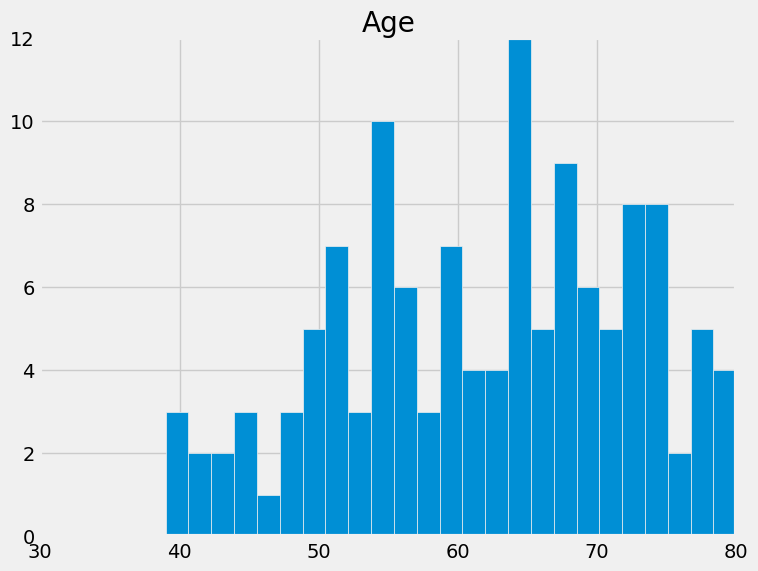

In [188]:
# To not have multiple instances of the same patients we only take the earliest image
metadata_firstYear = df_metadata.drop_duplicates(subset="Subject",keep='first')
metadata_firstYear.hist(column='Age',bins=25)
plt.show()

How the dataset is devided between male and female.
Note that PD is also more frequent among males in the general population

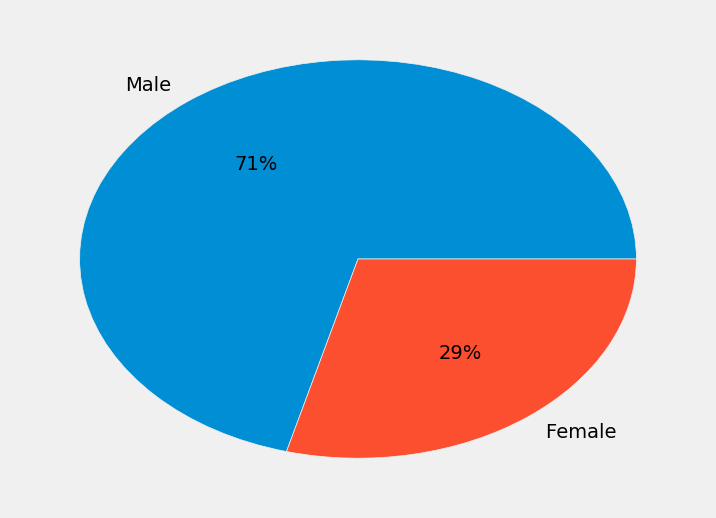

In [189]:
n_female = len(metadata_firstYear[metadata_firstYear["Sex"]=='F'])
n_male = len(metadata_firstYear[metadata_firstYear["Sex"]=='M'])
plt.pie([n_male,n_female], labels=['Male','Female'],autopct='%.0f%%')
plt.show()

How many subjects are Parkinson's disease patients and how many are healthy controls

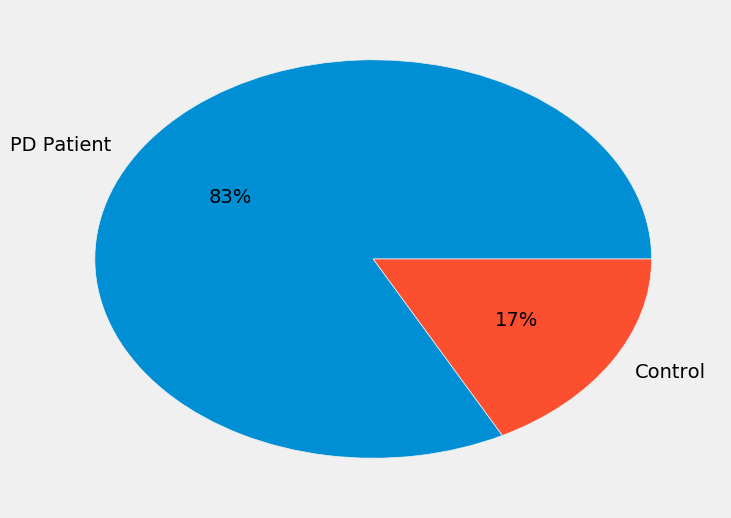

In [190]:
n_PD = len(metadata_firstYear[metadata_firstYear["Group"]=='PD'])
n_Control = len(metadata_firstYear[metadata_firstYear["Group"]=='Control'])
plt.pie([n_PD,n_Control], labels=['PD Patient','Control'], autopct='%.0f%%')
plt.show()

Check if the age distribution between healthy and PD patients any different

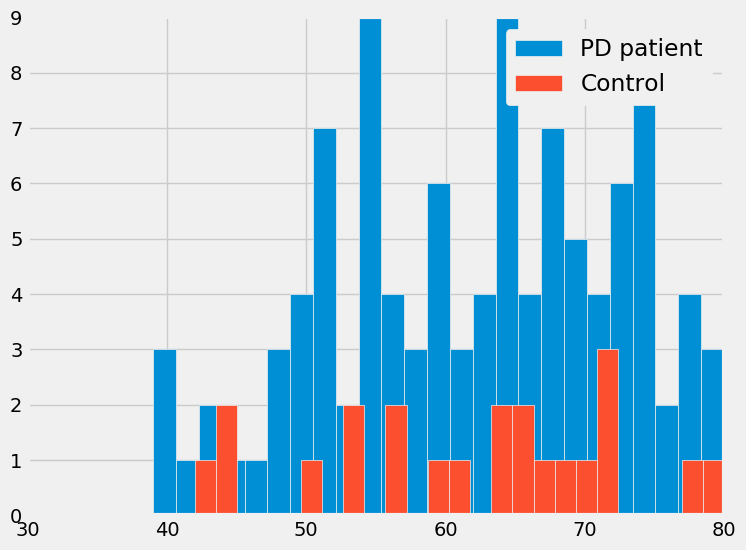

In [191]:
plt.hist(metadata_firstYear[metadata_firstYear["Group"]=='PD']['Age'],bins=25,label='PD patient')
plt.hist(metadata_firstYear[metadata_firstYear["Group"]=='Control']['Age'],bins=25, label='Control')
plt.legend()
plt.show()

How about age difference between female and male patients?

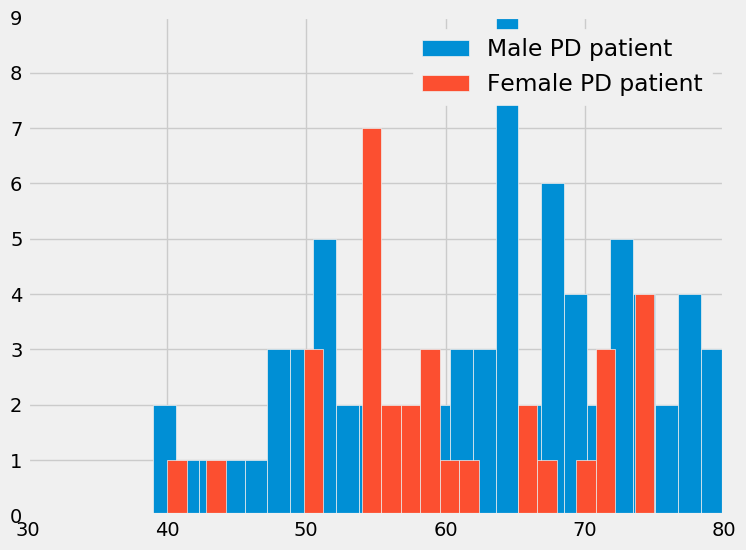

In [192]:
plt.hist(metadata_firstYear[(metadata_firstYear["Group"]=='PD') & (metadata_firstYear["Sex"]=='M')]['Age'],bins=25,label='Male PD patient')
plt.hist(metadata_firstYear[(metadata_firstYear["Group"]=='PD') & (metadata_firstYear["Sex"]=='F')]['Age'],bins=25,label='Female PD patient')
plt.legend()
plt.show()

Overall the dataset seems to be well balanced in age but there are considerable more men than women. This might be caused by the fact that males are more often affected than females

# 2) Data structure organization 
(BIDS: http://bids.neuroimaging.io/)
``` 
import os
subjects = os.listdir()
subjects = [subject[:4] for subject in subjects]
subjects = list(set(subjects))
for subject in subjects:
	os.system('mkdir ' +subject)
	os.system('mkdir ' +subject+'/func')
	os.system('mv '+subject+'* ' +subject+'/func')
```

We used the function ```folders_organization``` to further organize the structure of the data before running the preprocessing. The function is called from the python script `folders_organization.py` to get it working on the cluster.

# 3) Preprocessing

Credits: https://miykael.github.io/nipype_tutorial/

The script ```preprocessing.py``` was applied to the data on the cluster. This script is available along with this notebook.

The main steps that have been applied are the following:
a) Motion correction
b) Coregistration of functional images to anatomical images
c) Smoothing
d) Normalization into the standard MNI space

## Preprocessing results

In [9]:
# The following code is used to load the preprocessed files

basedir_PD = '/Volumes/myFatDrive/adaproject/PD/'
basedir_control = '/Volumes/myFatDrive/adaproject/control/'

task = '/ep2d_RESTING_STATE/'

func_filesPD = []

for fn in sorted(os.listdir(basedir_PD)):
    if fn[0]=='3' or fn[0]=='4':
        for fn2 in sorted(os.listdir(basedir_PD+fn+task)):
            if fn2[0]=='2':
                func_filesPD.append(basedir_PD+fn+task+fn2+'/swrrest.nii')

func_filesControl = []

for fn in sorted(os.listdir(basedir_control)):
    if fn[0]=='3' or fn[0]=='4':
        for fn2 in sorted(os.listdir(basedir_control+fn+task)):
            if fn2[0]=='2':
                func_filesControl.append(basedir_control+fn+task+fn2+'/swrrest.nii')

anat_example = '/Volumes/myFatDrive/adaproject/control/3106/ep2d_RESTING_STATE/2015-03-30_14_21_51/wranat_t1.nii'

In the following we plot the anatomical MRI image and mean fMRI image over time to show the results of the preprocessing.
The fMRI images belong respectively to a patient and a control. We can notice that certain brain regions of the patient are in average abnormally more active with respect to the control.

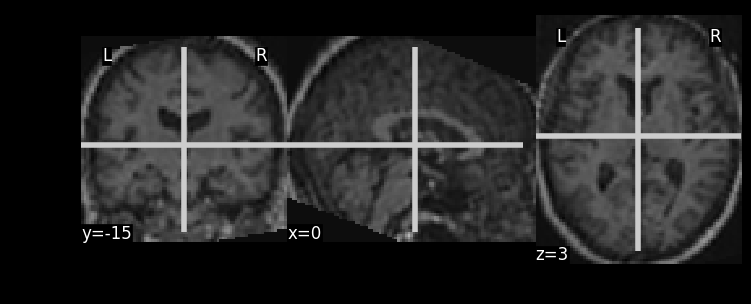

Example of anatomical MRI image


In [200]:
nilearn.plotting.plot_anat(anat_example)
show()
print('Example of anatomical MRI image')

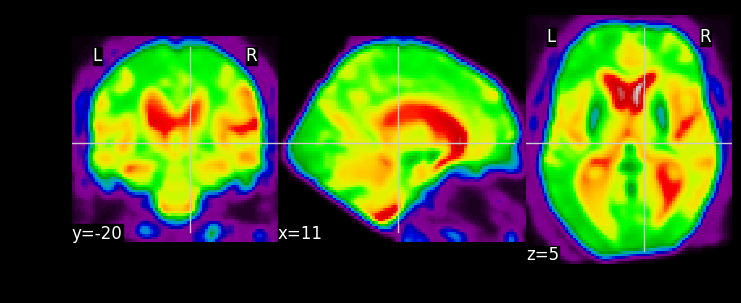

Example of mean fMRI image over time - PD patient


In [171]:
# Compute the mean resting state fMRI: we do the mean along the axis 3, which is time
mean_haxbyPD = mean_img(func_filesPD[1])

plot_epi(mean_haxbyPD)
show()

print('Example of mean fMRI image over time - PD patient')

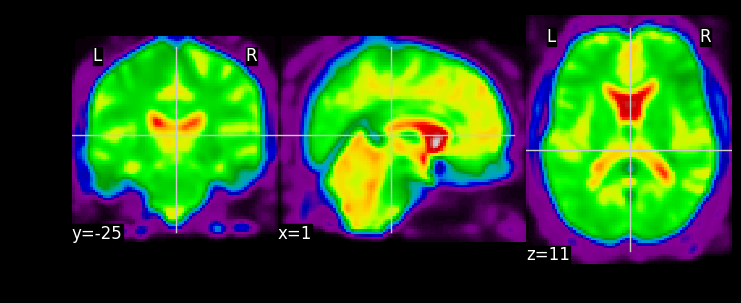

Mean of fMRI image over time  - control 


In [172]:
mean_haxbyControl = mean_img(func_filesControl[1])

plot_epi(mean_haxby)
show()

print('Mean of fMRI image over time  - control ')

# 3) Clustering
Credits: http://nilearn.github.io/index.html

## Extracting a brain mask

In order to perform fMRI analysis we need to extract only the voxels that are inside the brain area through a mask. This way we can get rid of the noisy background.

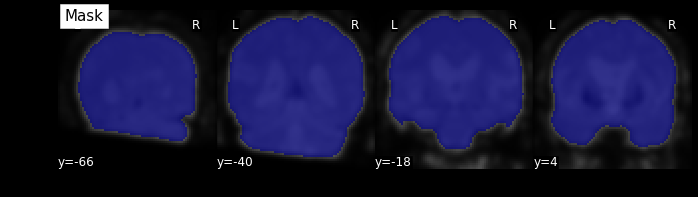

/Users/elisabettamessina/.local/lib/python3.6/site-packages/nilearn/input_data/base_masker.py:98: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


In [10]:
nifti_masker = NiftiMasker(standardize=True, mask_strategy='epi',
                           memory="nilearn_cache", memory_level=2,
                           smoothing_fwhm=8)
nifti_masker.fit(func_filesPD[0])
mask_img = nifti_masker.mask_img_

# calculate mean image for the background
mean_func_img = mean_img(func_filesPD[0])

plot_roi(mask_img, mean_func_img, display_mode='y', cut_coords=4, title="Mask")
show()

# The fit_transform call computes the mask and extracts the time-series from the files:
fmri_masked = nifti_masker.fit_transform(func_filesPD[0])

# We can retrieve the numpy array of the mask
mask = nifti_masker.mask_img_.get_data().astype(bool)

## Extract time series
The time series are the values of the intensities of each voxel at each time point. If we plot a few random the first 150 points for the patients and the controls, we can see how the time series averages differ across the two classes. 

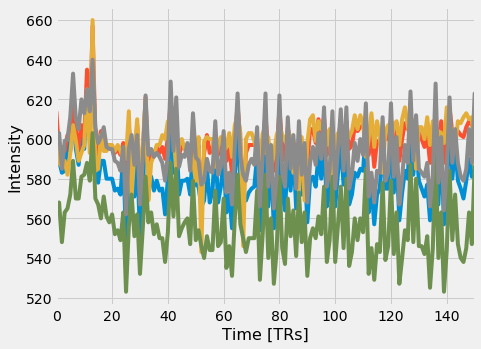

In [11]:
masked_dataPD = apply_mask(func_filesPD[1], mask_img)

# masked_data shape is (timepoints, voxels). We can plot the first 150
# timepoints from two voxels

# And now plot a few of these
plt.figure(figsize=(7, 5))
plt.plot(masked_dataPD[:, :5])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

show()

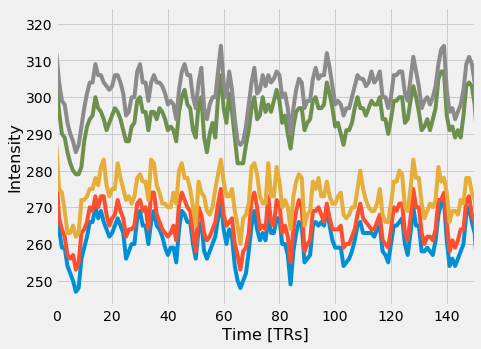

In [12]:
masked_dataControl = apply_mask(func_filesControl[1], mask_img)

# masked_data shape is (timepoints, voxels). We can plot the first 150
# timepoints from two voxels

# And now plot a few of these
plt.figure(figsize=(7, 5))
plt.plot(masked_dataControl[:, :5])
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 150)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

show()

After that, we thought of finding out which of the voxels correspond to brain areas which might be important for the disease. So, we thought of using clustering. We used three different ways of clustering, ICA (slow and fast), Ward clustering and Dictionary clustring.


## fast ICA
Salient features present in some of the extracted Independent Components (ICs) can be interpreted as brain networks, but the segmentation of the corresponding regions from ICs is still not well-defined, as described [here](https://arxiv.org/abs/1006.2302).

Fast ICA was computed for one single patient.

In [212]:
n_components = 10
ica = FastICA(n_components=n_components, random_state=42)
components_masked = ica.fit_transform(fmri_masked.T).T

components = nifti_masker.inverse_transform(components_masked)


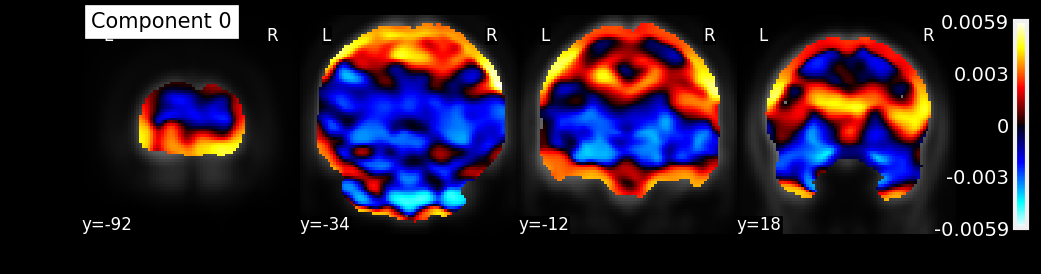

In [213]:
# Visualize results

plot_stat_map(index_img(components, 0), mean_func_img,
              display_mode='y', cut_coords=4, title="Component 0")

show()

 ## Ward clustering

Ward clustering applies an analysis of variance problem, instead of using distance metrics or measures of association. 
The algorithm was applied to the entire set of PD patients and show an average region of activity. The parcellations are finer in this case.

In [ ]:
# Compute connectivity matrix: which voxel is connected to which


shape = mask.shape
connectivity = image.grid_to_graph(n_x=shape[0], n_y=shape[1],
                                   n_z=shape[2], mask=mask)

start = time.time()
ward = FeatureAgglomeration(n_clusters=1000, connectivity=connectivity,
                            linkage='ward', memory='nilearn_cache')
ward.fit(fmri_masked)
print("Ward agglomeration 1000 clusters: %.2fs" % (time.time() - start))


# Unmask the labels

# Avoid 0 label
labels = ward.labels_ + 1
labels_img = nifti_masker.inverse_transform(labels)

from nilearn.image import mean_img
mean_func_img = mean_img(func_filesPD)


first_plot = plot_roi(labels_img, mean_func_img, title="Ward parcellation",
                      display_mode='xz')

# common cut coordinates for all plots
cut_coords = first_plot.cut_coords




show()


#SAVE
labels_img.to_filename('parcellation.nii')

We decided to use ICA because we have better control on the number of components, (with higher number of components, there is no convergence). For this algorithm, we run the clustering separately on the PD patients and the control group.

## ICA group analysis

We do not run the following cell again to avoid the time taken to rerun and the same goes for the other cell with control groups.

In [ ]:
canica = CanICA(n_components=20, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)
canica.fit(func_filesPD)

# Retrieve the independent components in brain space
components_img = canica.masker_.inverse_transform(canica.components_)
# SAVE
components_img.to_filename('canica_resting_state.nii.gz')

/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:920: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


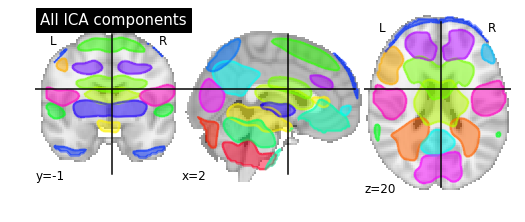

In [55]:
# Plot all ICA components together
plot_prob_atlas(components_img, title='All ICA components')
show()

In [56]:
components_img.to_filename('canica_resting_statePD.nii.gz')

In [ ]:
#Second group
canica = CanICA(n_components=20, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)
canica.fit(func_filesControl)

# Retrieve the independent components in brain space
components_img = canica.masker_.inverse_transform(canica.components_)
# SAVE
#components_img.to_filename('canica_resting_stateControl.nii.gz')

/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:920: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


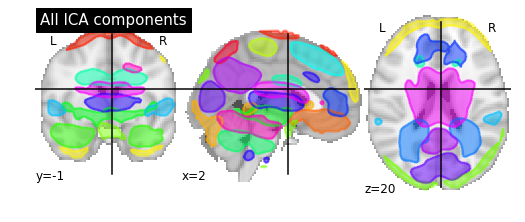

In [76]:
# Plot all ICA components together
plot_prob_atlas(components_img, title='All ICA components')
show()

In [77]:
components_img.to_filename('canica_resting_stateControl.nii.gz')

We plot each of the independent components separately now.

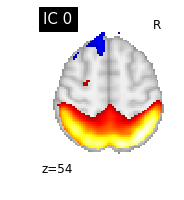

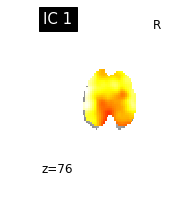

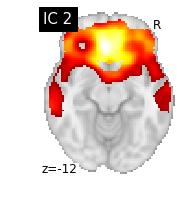

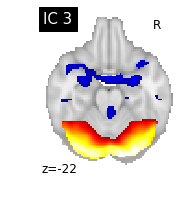

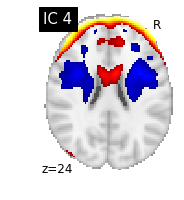

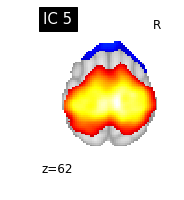

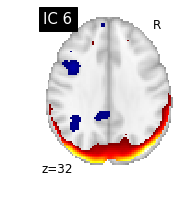

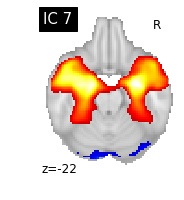

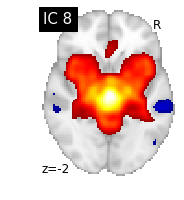

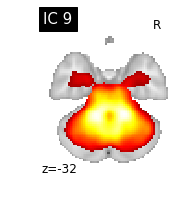

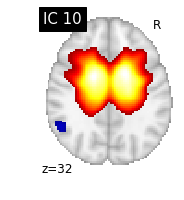

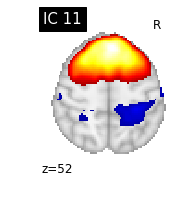

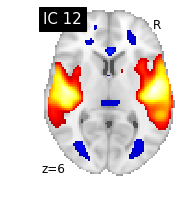

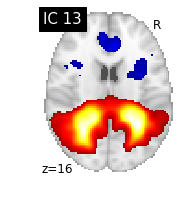

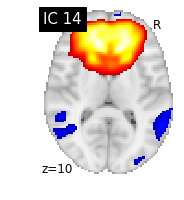

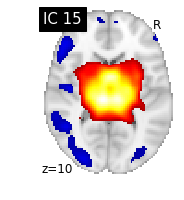

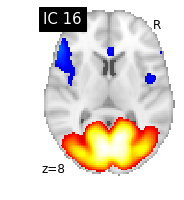

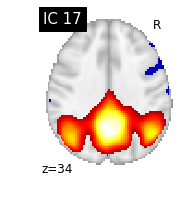

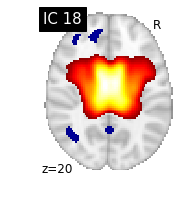

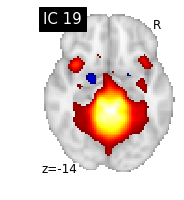

In [78]:
# plot the map for each ICA component separately
for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)
show()

# Comparison Dictionary Learning and ICA
Create two decomposition estimators

In [214]:
n_components = 10

In [215]:
dict_learning = DictLearning(n_components=n_components,
                             memory="nilearn_cache", memory_level=2,
                             verbose=1,
                             random_state=0,
                             n_epochs=1)

In [216]:
canica = CanICA(n_components=n_components,
                memory="nilearn_cache", memory_level=2,
                threshold=3.,
                n_init=1,
                verbose=1)

Fit both estimators

In [ ]:
estimators = [dict_learning, canica]
names = {dict_learning: 'DictionaryLearning', canica: 'CanICA'}
components_imgs = []

for estimator in estimators:
    print('[Example] Learning maps using %s model' % names[estimator])
    estimator.fit(func_filesPD)
    print('[Example] Saving results')
    # Decomposition estimator embeds their own masker
    masker = estimator.masker_
    # Drop output maps to a Nifti   file
    components_img = masker.inverse_transform(estimator.components_)
    components_img.to_filename('%s_resting_state.nii.gz' %
                               names[estimator])
    components_imgs.append(components_img)

[Example] Learning maps using DictionaryLearning model
[MultiNiftiMasker.fit] Loading data from [/Volumes/myFatDrive/adaproject/PD/3105/ep2d_RESTING_STATE/2013-04-18_12_01_06/swrrest.nii, /Volumes/myFatDrive/adaproject/PD/3105/ep2d_RESTING_STATE/2015-03-30_15_27_11/swrrest.nii, /Volumes/myFatDri
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[DictLearning] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Volumes/myFatDrive/adaproject/PD/3105/ep2d_RESTING_STATE/2013-04-18_12_01_06/swrrest.nii')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/Volumes/myFatDrive/adaproject/PD/3105/ep2d_RESTING_STATE/2015-03-30_15_27_11/swrrest.nii')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMa

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s finished


________________________________________________________________________________
[Memory] Calling nilearn.decomposition.dict_learning._compute_loadings...
_compute_loadings(array([[-0.001831, ...,  0.000254],
       ..., 
       [ 0.000185, ...,  0.001864]]), 
array([[ 8.209784, ...,  7.10028 ],
       ..., 
       [ 1.971583, ..., -0.35333 ]]))
_________________________________________________compute_loadings - 2.3s, 0.0min
[DictLearning] Learning dictionary
________________________________________________________________________________
[Memory] Calling sklearn.decomposition.dict_learning.dict_learning_online...
dict_learning_online(array([[ 8.209784, ...,  1.971583],
       ..., 
       [ 7.10028 , ..., -0.35333 ]]), 
10, alpha=10, n_iter=10046, batch_size=20, method='cd', dict_init=array([[-0.092474, ..., -0.164328],
       ..., 
       [-0.311698, ...,  0.197699]]), verbose=0, random_state=0, return_code=True, shuffle=True, n_jobs=1)
____________________________________________dic

/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s finished


_________________________________________________________fastica - 15.9s, 0.3min
[Example] Saving results


In [ ]:
# Selecting specific maps to display: maps were manually chosen to be similar
indices = {dict_learning: 1, canica: 31}
# We select relevant cut coordinates for displaying
cut_component = index_img(components_imgs[0], indices[dict_learning])
cut_coords = find_xyz_cut_coords(cut_component)
for estimator, components in zip(estimators, components_imgs):
    # 4D plotting
    plot_prob_atlas(components, view_type="filled_contours",
                    title="%s" % names[estimator],
                    cut_coords=cut_coords, colorbar=False)
    # 3D plotting
    plot_stat_map(index_img(components, indices[estimator]),
                  title="%s" % names[estimator],
                  cut_coords=cut_coords, colorbar=False)
show()

/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:920: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


## Functional connectivity matrices for group analysis of connectomes

In [87]:
# We use probabilistic regions of interest (ROIs) from the MSDL atlas.

msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, msdl_data.networks))


Dataset created in /Users/elisabettamessina/nilearn_data/msdl_atlas

MSDL has 39 ROIs, part of the following networks :
[b'Aud', b'Aud', b'Striate', b'DMN', b'DMN', b'DMN', b'DMN', b'Occ post', b'Motor', b'R V Att', b'R V Att', b'R V Att', b'R V Att', b'Basal', b'L V Att', b'L V Att', b'L V Att', b'D Att', b'D Att', b'Vis Sec', b'Vis Sec', b'Vis Sec', b'Salience', b'Salience', b'Salience', b'Temporal', b'Temporal', b'Language', b'Language', b'Language', b'Language', b'Language', b'Cereb', b'Dors PCC', b'Cing-Ins', b'Cing-Ins', b'Cing-Ins', b'Ant IPS', b'Ant IPS'].


Downloaded 209734 of 209734 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)
Extracting data from /Users/elisabettamessina/nilearn_data/msdl_atlas/5d25e157f36214b8ca9a12fd417aac1c/MSDL_rois.zip..... done.


In [ ]:
msdl_data.shape

In [89]:
masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2.5, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1)

In [146]:
pd_subjects=[]
pooled_subjects=[]
sites_names=[]
pd_subjects=[]

for func_file in func_filesPD:
    time_series = masker.fit_transform(func_file)
    pooled_subjects.append(time_series)
    pd_subjects.append(time_series)

print('Data has {0} PD subjects.'.format(len(pd_subjects)))


/Users/elisabettamessina/anaconda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:430: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


Data has 78 PD subjects.


In [147]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')

In [159]:
correlation_matrices = correlation_measure.fit_transform(pd_subjects)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of patients are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))

Correlations of ADHD patients are stacked in an array of shape (78, 39, 39)


In [160]:
mean_correlation_matrix = correlation_measure.mean_
print('Mean correlation has shape {0}.'.format(mean_correlation_matrix.shape))

Mean correlation has shape (39, 39).


In [161]:
def samplemat(dims):
    """Make a matrix with all zeros and increasing elements on the diagonal"""
    aa = np.zeros(dims)
    for i in range(min(dims)):
        aa[i, i] = i
    return aa

def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        #plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        #plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
        #                     title=title, figure=fig, colorbar=False)
        plt.matshow(matrix)
        plt.show()

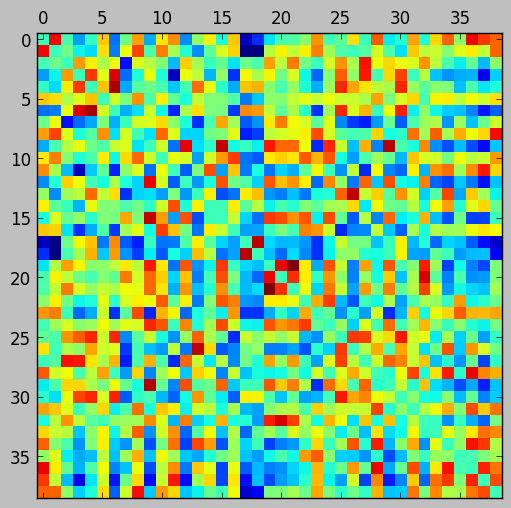

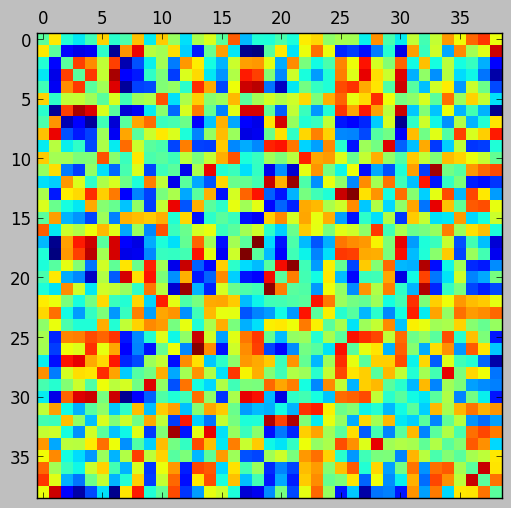

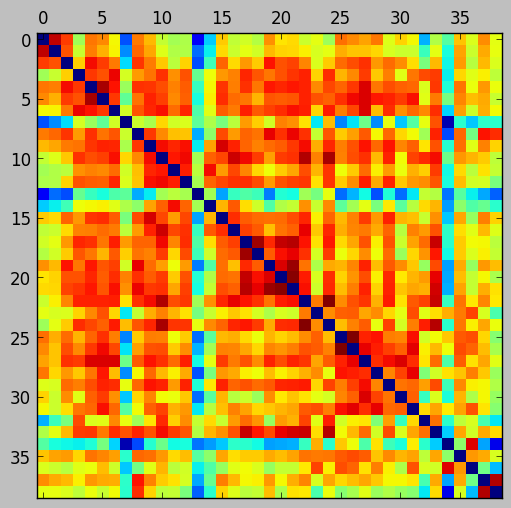

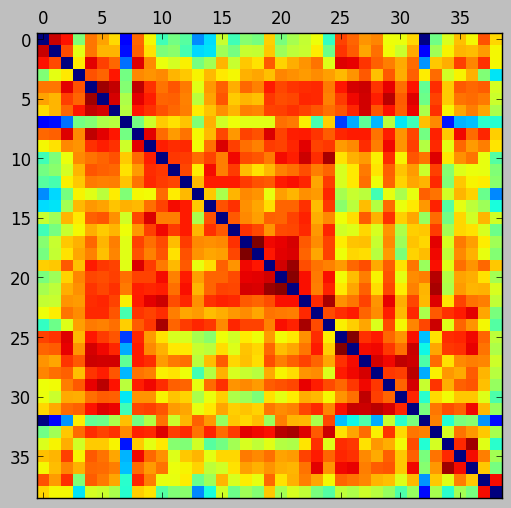

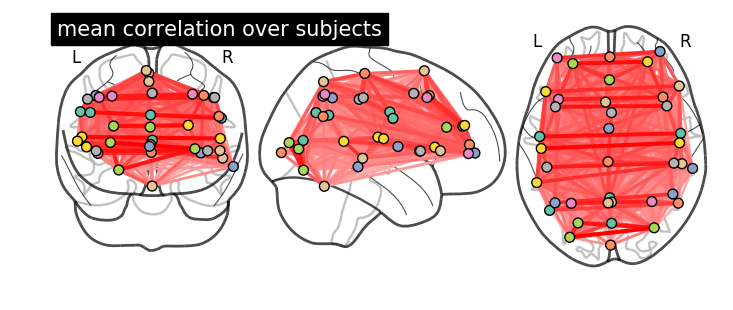

In [164]:
plot_matrices(correlation_matrices[:4], 'correlation')
plotting.plot_connectome(mean_correlation_matrix, msdl_coords,
                         title='mean correlation over subjects')
show()

## Convolutional Neural Network

First we load in one subject example to try on the network

Convolutional neural networks have many times proven to be a powerful tool in image analysing tasks [as here](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf). In our case we used the following network architecture to analyse the fMRI images after preprocessing: 

The network was trained using fMRI images from 85 subjects and tested on 22 subjects for a total of 107 subjects. Out of these 107, 11 subjects were controls. A high level of accuracy for both the training and testing set was reached already after one training epoch. This high level of accuracy is not so impressive considering that 90% accuracy could be reached by guessing every subject was a PD patient. 

We made an attempt to visualise what features the network was learning by visualising the neural activations in each layer of the network.

In [5]:
file = '/Users/freyr/CASTOR3/ep2d/3350/func/3350_ep2d_RESTING_STATE_20150514161838.nii'
img = nib.load(file)
img = img.get_data()
img = np.array(img)
shp0,shp1,shp2,shp3 = img.shape
# Put the time channels on the same dimension as the depth
img = np.reshape(img,(1,shp0,shp1,shp2*shp3))

In [3]:
import nibabel as nib
import matplotlib
import glob
import pickle
import keras
from keras.models import load_model
from keras import models
import os

Using TensorFlow backend.
/Users/freyr/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
img.shape

(1, 68, 66, 8400)

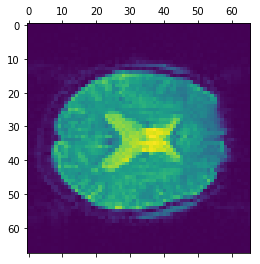

In [7]:
plt.matshow(img[0,:,:,4200])
plt.show()

We generated the neural network by running CNN.py. Now we'll reload it and analyse its properties

In [9]:
model = load_model('/Users/freyr/CASTOR3/model_10_epoch.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (1, 66, 64, 32)           2419232   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (1, 33, 32, 32)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 31, 30, 64)           18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (1, 15, 15, 64)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (1, 13, 13, 128)          73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (1, 6, 6, 128)            0         
_________________________________________________________________
conv2d_4 (Conv2D)            (1, 4, 4, 128)            147584    
__________

We want to see what features the network is learning from

In [10]:
# Extracts the outputs from layers:
layer_outputs = [layer.output for layer in model.layers]
# Creates a model that will return the outputs given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [11]:
# Run the image through the network
activations = activation_model.predict(img)

In [12]:
def plot_layer(i): 
    # For plotting the output activations
    layer_name = model.layers[i].name


    images_per_row = 16
    layer_activation = activations[i]
    n_features = layer_activation.shape[-1]
    size1 = layer_activation.shape[1]
    size2 = layer_activation.shape[2]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size1 * n_cols, images_per_row * size2))

    # Tiling each filter into horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                            :, :,
                                            col * images_per_row + row]
            # Post-process the feature to make it better visually
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size1 : (col + 1) * size1,
                        row * size2 : (row + 1) * size2] = channel_image

    # Display the grid
    scale = 1. / size1
    matplotlib.rcParams['figure.figsize'] = (18,10)
    plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    matplotlib.rcParams['figure.figsize'] = (18,10) 
    plt.show()

/Users/freyr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


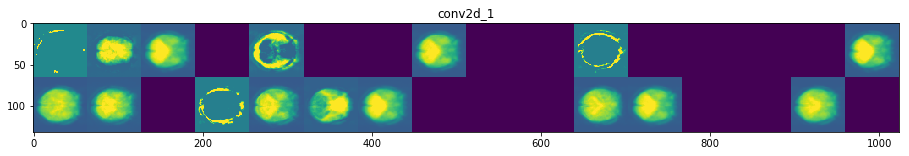

In [13]:
# Output channels from the first CNN layer
plot_layer(0)

/Users/freyr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


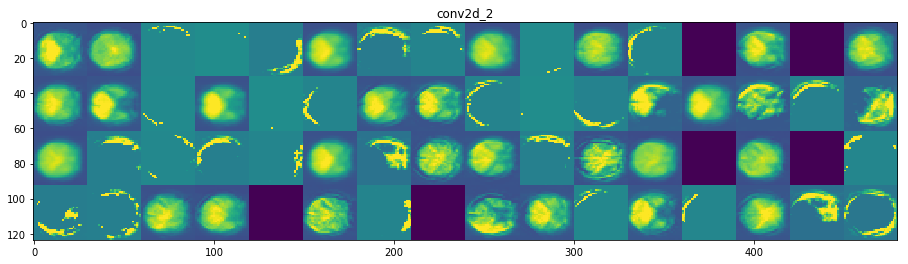

In [14]:
# Output channels from the second CNN layer

plot_layer(2)

/Users/freyr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


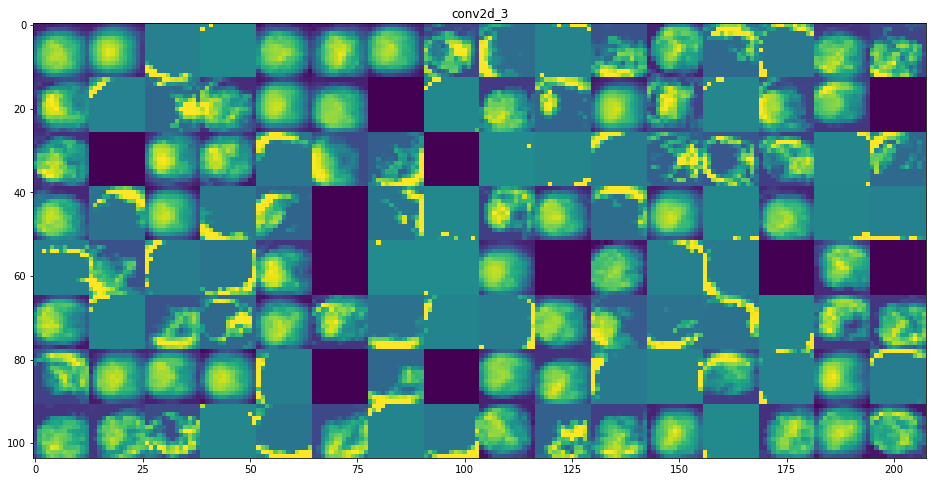

In [15]:
# Output channels from the third CNN layer

plot_layer(4)

/Users/freyr/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


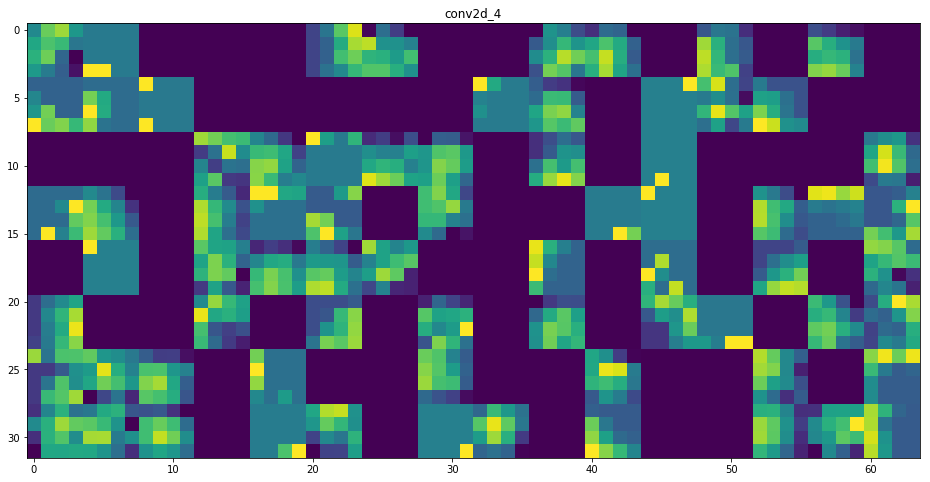

In [16]:
# Output channels from the fourth CNN layer

plot_layer(6)

We can see roughly what features the network is focusing on in the first layer but in the fourth one the features get very abstract and difficult to interpret

Finally we'll load the training history and see how the accuracy developed with each epoch of training

In [17]:
history = pickle.load(open('/Users/freyr/CASTOR3/trainHistoryDict','rb'))

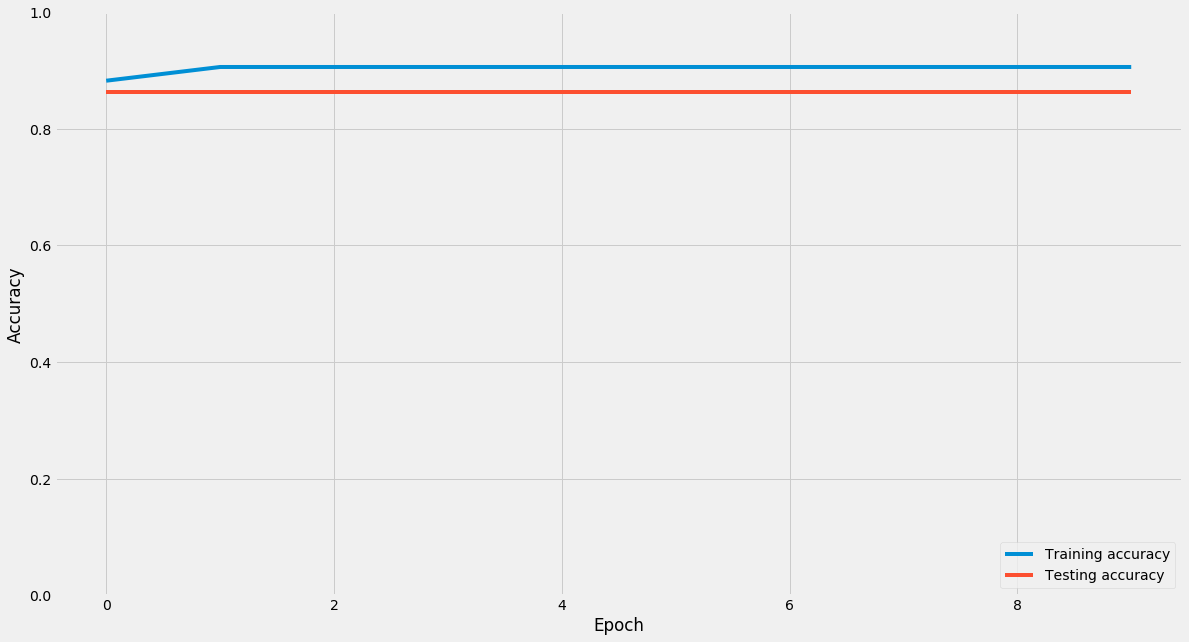

In [18]:
plt.style.use('fivethirtyeight')
plt.plot(history['acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Testing accuracy')
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=4)
plt.show()